# Lab Deep Learning / Multi-Layer Perceptron for binary-classification / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2022/09/19

For any remark or suggestion, please feel free to contact me.

In [1]:
student = True

## Objective:

The objective of this lab is to develop a two hidden layers MLP to perform **binary classification**.

We will use a MLP with 2 hidden layer with $n_{h1}=20$ and $n_{h2}=10$ hidden units and ```relu``` activation functions.
You will perform 10.000 iterations (epochs) of SGD to find the parameters.

Note: for this lab, we do not separate the dataset into a train, validation and test part.

### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write NN model in pytorch. 

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,W2,b2,W3,b3), writing the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a binary classification problem, we will use a Binary Cross Entropy loss (use ```torch.nn.BCELoss``` for Model B and C).

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.1.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```. 

### Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

### Documentation:
- NN: https://pytorch.org/docs/stable/nn.html
- Autograd: https://pytorch.org/docs/stable/autograd.html
- Optim: https://pytorch.org/docs/stable/optim.html


## Load the python packages

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

student = True

In [38]:
print(torch.__version__)

1.8.1+cu102


## Dataset

We take the usual circle dataset from sklearn.

In [25]:
from sklearn import datasets

In [26]:
X_np, y_np = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

We convert the ```numpy tensors``` to ```torch tensors```. 
The difference being that the latters allows to do automatic gradient differentiation (back-propagation).

In [27]:
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
y = y.view(len(y), 1)

In [28]:
print(X.size())
print(y.size())
print(X.mean(dim=0))
print(X.std(dim=0))

torch.Size([1000, 2])
torch.Size([1000, 1])
tensor([-0.0025,  0.0079])
tensor([0.5947, 0.5859])


## Normalization

In [29]:
X -= X.mean(dim=0)
X /= X.std(dim=0)
print(X.mean(dim=0))
print(X.std(dim=0))

tensor([-7.6294e-09, -1.0788e-08])
tensor([1., 1.])


## Definition of the hyper-parameters

In [30]:
n_in = X.shape[1]
n_h1 = 20
n_h2 = 10
n_out = 1

nb_epoch = 10000
alpha = 0.1

## Model 1 (writing the network equations)




### Parameter initialization

**Using torch.Tensors**.
You will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch.Tensors``` instead of ```numpy.Array```. 

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from ```loss```. Then, for all tensors you've created and for which you declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

Example: ```W1 = torch.Tensor(..., requires_grad=True)``` ... ```loss.backward``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

**Random initialization**. Don't forget that the weight $W_1, W_2, \cdots$ matrices **should be initialized randomly with small values**; while the bias vectors $b_1, b_2, \cdots$can be initialized to zero.

In [31]:
# --- We first initialize the variables of the network (W1, b1, ...)
if student:
    # --- START CODE HERE (01)
    W1 = torch.rand(n_in, n_h1) * 0.01
    W1.requires_grad = True
    b1 = torch.zeros((1, n_h1))
    b1.requires_grad = True
    
    W2 = torch.rand((n_h1, n_h2)) * 0.01
    W2.requires_grad = True
    b2 = torch.rand((1, n_h2), )
    b2.requires_grad = True

    W3 = torch.rand((n_h2, n_out), ) * 0.01
    W3.requires_grad = True
    b3 = torch.zeros((1, n_out), )
    b3.requires_grad = True
    # --- END CODE HERE

In [32]:
W1.shape

torch.Size([2, 20])

In [33]:
W2.shape

torch.Size([20, 10])

In [34]:
W3.shape

torch.Size([10, 1])

### Define the model

We write a function to perform the forward pass (using pytorch operators, not numpy operators) taking X as input and returning hat_y as output.

In [35]:
def model(X):
    if student:
        # --- START CODE HERE (02)
        A0 = X
        Z1 = torch.mm(A0, W1) + b1
        A1 = nn.functional.relu(Z1)
        Z2 = torch.mm(A1, W2) + b2
        A2 = nn.functional.relu(Z2)
        Z3 = torch.mm(A2, W3) + b3
        A3 = torch.sigmoid(Z3)
        hat_y = A3
        # --- END CODE HERE
    return hat_y

### Main training loop

We iterate over epochs (we do not perform split into mini-batch here)
For each iteration, we
- a) perform the forward pass, 
- b) compute the loss/cost, 
- c) compute the backward pass to get the gradients of the cost w.r.t. the parameters W1, b1, ...
- d) perform the update of the parameters W1, b1, ...

***Important: pytorch restriction***
When you update the parameters (W1, b1, ...) but subtracting a small part of the gradient, you should that ``inplace`` (W1 -= ??? and not W1 = W1 - ???). Otherwise pytorch will overide W1 by its value (it will eras its .grad filed).


In [36]:
for num_epoch in range(0, nb_epoch):

    # --- a) Forward pass: X (n_in, m), hat_y (n_out, m)
    hat_y = model(X)

    # -- We clip hat_y in order to avoid log(0) in the loss
    eps = 1e-10
    hat_y = torch.clamp(hat_y, eps, 1-eps)
    
    # --- b) Computing the loss/cost
    if student:
        # --- START CODE HERE (03)
        loss = - (y * torch.log(hat_y) + (1-y) * torch.log(1-hat_y))
        cost = torch.mean(loss)
        # --- END CODE HERE
    
    if num_epoch % 500 == 0:
        # print(loss)
        print('epoch {}, loss {}'.format(num_epoch, cost))

    # --- c) Backward pass
    cost.backward()
    
    # --- "with torch.no_grad()" temporarily set all the requires_grad flag to false
    with torch.no_grad():
        # --- d) perform the update of the parameters W1, b1, ...
        if student:
            # --- the gradients dLoss/dW1 is stored in W1.grad, dLoss/db1 is stored in b1.grad, ...
            # --- START CODE HERE (04)
            W1 -= alpha * W1.grad
            b1 -= alpha * b1.grad
            W2 -= alpha * W2.grad
            b2 -= alpha * b2.grad
            W3 -= alpha * W3.grad
            b3 -= alpha * b3.grad
            # --- END CODE HERE

    # --- We need to set to zero all gradients (otherwise they are cumulated)
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()

epoch 0, loss 0.6932157278060913
epoch 500, loss 0.6931473612785339
epoch 1000, loss 0.693146824836731
epoch 1500, loss 0.6931463479995728
epoch 2000, loss 0.693145751953125
epoch 2500, loss 0.6931449770927429
epoch 3000, loss 0.6931436657905579
epoch 3500, loss 0.6931416392326355
epoch 4000, loss 0.6931383609771729
epoch 4500, loss 0.6931318640708923
epoch 5000, loss 0.6931182146072388
epoch 5500, loss 0.6930821537971497
epoch 6000, loss 0.6929495334625244
epoch 6500, loss 0.6919629573822021
epoch 7000, loss 0.6602393388748169
epoch 7500, loss 0.277773916721344
epoch 8000, loss 0.2653074264526367
epoch 8500, loss 0.26466473937034607
epoch 9000, loss 0.2644187808036804
epoch 9500, loss 0.2642856538295746


## Model 2 (using nn.sequential)

Here, you will use the package ```torch.nn``` which comes with a predefined set of layers. The syntax is close to the one of ```keras```(```Sequential```), but differs in the fact that layers are splitted into the matrix multiplication followed by a non-linear activations (```keras```merge both using the ```Dense```layers).

The model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. It is therefore a convenient way to write simple sequential networks.

In [39]:
?nn.Linear

Init signature: nn.Linear(in_features: int, out_features: int, bias: bool = True) -> None
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
      additional dimensions and :math:`H_{in} = \text{in\_features}`
    - Output: :math:`(N, *, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. The values are
        initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
        :math:`k = \frac{1}{\text{in\_featu

In [40]:
if student:
    # --- START CODE HERE (05)
    my_model = nn.Sequential(
                nn.Linear(n_in, n_h1),
                nn.ReLU(),
                nn.Linear(n_h1, n_h2),
                nn.ReLU(),
                nn.Linear(n_h2, n_out),
                nn.Sigmoid()
    )
    # --- END CODE HERE


### Criterion and Optimization

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update algorithms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build optimizer functions (within ```torch.optim```)

In [47]:
if student:
    # --- START CODE HERE (08)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(my_model.parameters(), lr=alpha)
    # --- END CODE HERE


### Main training loop

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```hat_y = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

epoch 0, loss 0.704404354095459
epoch 500, loss 0.27304643392562866
epoch 1000, loss 0.2613682150840759
epoch 1500, loss 0.2597896456718445
epoch 2000, loss 0.25906842947006226
epoch 2500, loss 0.25857019424438477
epoch 3000, loss 0.2582399249076843
epoch 3500, loss 0.25800639390945435
epoch 4000, loss 0.2578281760215759
epoch 4500, loss 0.25767645239830017
epoch 5000, loss 0.25753358006477356
epoch 5500, loss 0.25741252303123474
epoch 6000, loss 0.25731003284454346
epoch 6500, loss 0.25721511244773865
epoch 7000, loss 0.2571322023868561
epoch 7500, loss 0.2570575773715973
epoch 8000, loss 0.25699037313461304
epoch 8500, loss 0.2569308876991272
epoch 9000, loss 0.2568756639957428
epoch 9500, loss 0.25682714581489563


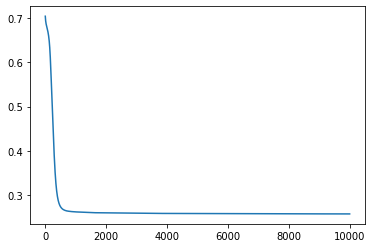

In [48]:
loss_l = []
for num_epoch in range(nb_epoch):
  
    if student:
        # --- START CODE HERE (09)
        hat_y = my_model(X) # Forward pass: Compute predicted y by passing  x to the model          
        loss =  criterion(hat_y, y)# Compute loss 
        # Zero gradients, perform a backward pass, and update the weights. 
        optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
        loss.backward() # perform back-propagation
        optimizer.step() # update the weights
        # --- END CODE HERE
        
    loss_l.append(loss.item())

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))
        
# ----------------
plt.plot(loss_l);

## Model 3 (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init__``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. 

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [57]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()
        
        if student:
            # --- START CODE HERE (06)
            self.fc1 = nn.Linear(n_in, n_h1) # hidden layer 1
            self.fc2 = nn.Linear(n_h1, n_h2) # hidden layer 2
            self.fc3 = nn.Linear(n_h2, n_out) # output layer
            # --- END CODE HERE
        
    def forward(self, X):
        
        if student:
            # --- START CODE HERE (07)
            A0 = X
            A1 = nn.functional.relu(self.fc1(A0))   # activation function for hidden layer 1
            A2 = nn.functional.relu(self.fc2(A1)) # activation function for hidden layer 2
            A3 = torch.sigmoid(self.fc3(A2)) # activation function for output layer
            # --- END CODE HERE

        return A3

# --- START CODE HERE
my_model = Net(n_in, n_h1, n_h2, n_out)
# --- END CODE HERE

### Criterion and Optimization (same as for model 2 -> copy and paste your code)

In [58]:
if student:
    # --- START CODE HERE (08)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(my_model.parameters(), alpha)
    # --- END CODE HERE


### Main training loop (same as for model 2 -> copy and paste your code)


epoch 0, loss 0.6993516683578491
epoch 500, loss 0.27290570735931396
epoch 1000, loss 0.2625434696674347
epoch 1500, loss 0.2609767019748688
epoch 2000, loss 0.26046693325042725
epoch 2500, loss 0.26008081436157227
epoch 3000, loss 0.25976112484931946
epoch 3500, loss 0.2594917416572571
epoch 4000, loss 0.25918468832969666
epoch 4500, loss 0.2589274048805237
epoch 5000, loss 0.2587115168571472
epoch 5500, loss 0.2585200071334839
epoch 6000, loss 0.2583509087562561
epoch 6500, loss 0.2581990957260132
epoch 7000, loss 0.2580474615097046
epoch 7500, loss 0.2579165995121002
epoch 8000, loss 0.2577943205833435
epoch 8500, loss 0.25767847895622253
epoch 9000, loss 0.25756749510765076
epoch 9500, loss 0.2574576437473297


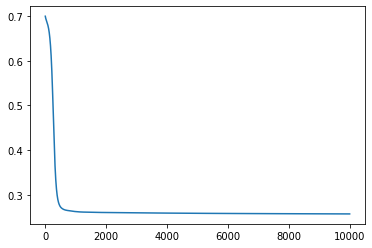

In [59]:
loss_l = []
for num_epoch in range(nb_epoch):
  
    if student:
        # --- START CODE HERE (09)
        hat_y = my_model.forward(X) # Forward pass: Compute predicted y by passing  x to the model          
        loss = criterion(hat_y,y) # Compute loss 
        # Zero gradients, perform a backward pass, and update the weights. 
        optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
        loss.backward() # perform back-propagation
        optimizer.step() # update the weights
        # --- END CODE HERE
        
    loss_l.append(loss.item())

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))
        
# ----------------
plt.plot(loss_l); 

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Model 1: Initialization of W1, b1, ... (01)
- 2) Model 1: Forward-pass (02)
- 3) Model 1: Loss and Cost computation  (03)
- 4) Model 1: Manual update of the parameters (04)
- 5) Model 2: using nn.sequential (05)
- 6) Model 3: using class definition: __init__ method (06)
- 7) Model 3: using class definition: forward method (07)
- 8) Model 2 and 3: Loss (criterion) and parameter update algorithms (optimizer) (08)
- 9) Model 2 and 3: code inside the loop (09)